In [1]:
import sys
sys.path.append("../")

In [2]:
import os.path as op
import random

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple


import pandas as pd
import yaml

from agents import GreedyAgent,RandomAgent
from agents.matchmanager import MatchManager
from agents.ml.classifier import ClassifierAgent
from agents.ml.regression import RegressionAgent
from agents.ml.regressionMulti import RegressionMultiAgent

from core.const import RED, BLUE
from core.game import GameBoard, GameState, vectorState, vectorStateInfo
from core.vectors import vectorAction, vectorActionInfo, vectorBoard, vectorBoardInfo
from scenarios import scenarioJunction
import warnings
import datetime

from sklearn import preprocessing

from multiprocessing import Pool
import pickle

from itertools import product
import json

import os
from utils.setup_logging import setup_logging
import joblib
import numpy as np




%matplotlib inline
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.figsize'] = (12,4)


In [3]:
def player(team:str, data:tuple, seed:int):
    if data[0] == 'gre':
        print(f'{team:5}-> GreedyAgent')
        return GreedyAgent(team, seed=seed)
    if data[0] == 'cls':
        print(f'{team:5}-> ClassifierAgent')
        return ClassifierAgent(team, data[1], seed=seed)
    if data[0] == 'reg':
        print(f'{team:5}-> RegressionAgent')
        return RegressionAgent(team, data[1], seed=seed)
    if data[0]=='ran':
        print(f'{team:5}-> RandomAgent')
        return RandomAgent(team, seed=seed)
    if data[0]=='regMulti':
        print(f'{team:5}-> RegressionAgentMulti')
        return RegressionMultiAgent(team,data[1],data[2],data[3],seed=seed)


    
    return None

In [4]:
def game(seed:int, red:tuple, blue:tuple) -> MatchManager:
    scenarios=[scenarioJunction]
    for s in scenarios:
        board, state = s()

        print('seed:   ', seed)

        playerRed = player(RED, red, seed)
        playerBlue = player(BLUE, blue, seed)

        mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
        while not mm.end:
            mm.nextStep()

        print('winner: ', mm.winner)

        return mm,board.name

In [5]:
def prepareDataFrames(mm:MatchManager):
    df_states = pd.DataFrame(
        columns=vectorStateInfo(),
        data=[vectorState(x) for x in mm.states_history]
    )

    df_actions = pd.DataFrame(
        columns=vectorActionInfo(),
        data=[vectorAction(x) for x in mm.actions_history]
    )

    df_board=pd.DataFrame(
        columns=vectorBoardInfo(),
        data=[vectorBoard(mm.board,x) for x in mm.states_history]
    )
    df_concat=pd.concat([df_states,df_actions,df_board],axis=1)
    df_concat.dropna(axis=1, how='all',inplace=True)
    
    df_red =pd.concat([mm.red.createDataFrame().reset_index(drop=True),df_concat[df_concat['action_team'] == 'red'].copy().drop('action_team', axis=1).reset_index(drop=True)],axis=1)

    df_blue =pd.concat([mm.blue.createDataFrame().reset_index(drop=True),df_concat[df_concat['action_team'] == 'blue'].copy().drop('action_team', axis=1).reset_index(drop=True)],axis=1)

    df_red['winner']=mm.winner
    df_blue['winner']=mm.winner
    
    df_red = df_red.set_index('count')
    df_blue = df_blue.set_index('count')

    return df_red, df_blue

def plotEntropy(df, color:str,data,winner,ax):
    df.score.plot(color=color, marker='.',ax=ax)
    df.entropy.plot(color='purple',ax=ax)
    df.standard_deviation.plot(color='green',ax=ax)

    for i, row in df[['score','action']].reset_index().iterrows():
        dy, ha, va = (-0, 'center', 'top') if 'Respond' in row.action else (10, 'center', 'bottom')
        ax.annotate(row.action, (row['count'], row.score), ha=ha, va=va, rotation=90, textcoords="offset points", xytext=(0,dy))
        
    for x in df[['turn']].reset_index().groupby('turn').max().values.tolist():
        ax.axvline(x=x[0]+0.5, color='orange')
    ax.legend(framealpha=1, frameon=True,loc='center left',bbox_to_anchor=(1,0.5))
    title=f'Entropy and Score for agent->{data[0]}. Winner:{winner} '

    ax.set_title(title)


    

In [6]:
def shiftMarker(df,winner):
    df_repl=df.tail(1)
    #action='Winner' if (df_repl.iloc[0]['team']=='red' and winner=='red') else 'Loser'
    #action='Winner' if (df_repl.iloc[0]['team']=='blue' and winner=='blue') else 'Loser'
    df_repl.index += 1
    
    df=df.append(df_repl)
    delta=datetime.timedelta(milliseconds=400)
    turn=(datetime.datetime.combine(datetime.date(1,1,1),df.iloc[-1]['time']) + delta).time()
    df.at[df.index[-1], 'time'] = turn
    if df.iloc[-1]['team']=='red':
        if df.iloc[-1]['winner']=='red':
            action='Winner'
        else:
            action='Loser'
    else:
        if df.iloc[-1]['winner']=='blue':
            action='Winner'
        else:
            action='Loser'
    df.at[df.index[-1], 'action'] = action
    df['score']=df['score'].shift(periods=1,fill_value=0)
    
    return df
    


In [7]:
def setTime(df,winner):

    df['time'] = pd.to_datetime(df['time'],errors='coerce')
    df['time']=df['time'].dt.time
    df= df.reset_index()
    df=shiftMarker(df,winner)
    x=df['time'].tolist()
    y=df['score'].tolist()
    df= df.set_index('time')
    return df,x,y


In [8]:
def setScore(df,model_path):
    model=joblib.load(os.path.join(os.getcwd(), model_path[1]))
    df= df.reset_index()
    df['score']=model.predict(df.drop(['meta_scenario', 'meta_p_red', 'meta_p_blue', 'meta_seed','meta_id','count','time','team','seed','score','action','entropy','standard_deviation','n_scores','scores','actions','winner','random_choice','n_choices','index'], axis=1, errors="ignore"))
    return df

In [9]:
def separateAction(df):
    df_move=df.loc[(df['action'] == 'Move')].copy()
    df_attack=df.loc[(df['action'] == 'Attack')].copy()
    df_attackground=df.loc[(df['action'] == 'AttackGround')].copy()
    df_moveloadinto=df.loc[(df['action'] == 'MoveLoadInto')].copy()
    df_passfigure=df.loc[(df['action'] == 'PassFigure')].copy()
    df_pass=df.loc[(df['action'] == 'Pass')].copy()
    df_passteam=df.loc[(df['action'] == 'PassTeam')].copy()
    df_attackrespond=df.loc[(df['action'] == 'AttackRespond')].copy()
    df_passrespond=df.loc[(df['action'] == 'PassRespond')].copy()
    
    
    return df_move,df_attack,df_attackground,df_moveloadinto,df_passfigure,df_pass,df_passteam,df_attackrespond,df_passrespond


    

    

In [17]:
def plotEntropyTime(df_red,df_blue,red_data,blue_data,winner,scenario,model_path):
    df_red.dropna(inplace=True)
    df_blue.dropna(inplace=True)
    position=[]
    labels=df_red['turn'].unique().tolist()
    loser='blue' if winner == 'red' else 'red'
    

    df_red=setScore(df_red,model_path)
    df_blue=setScore(df_blue,model_path)


    df_red,x_red,y_red=setTime(df_red,winner)
    df_blue,x_blue,y_blue=setTime(df_blue,winner)
    
    
    if(red_data[0]=='ran'):
        df_red['standard_deviation']=0
    if(blue_data[0]=='ran'):
        df_blue['standard_deviation']=0
        
    df_red['standard_deviation']=df_red['standard_deviation'].mul(-1)


    fig, ax = plt.subplots()
    df_move_r,df_attack_r,df_attackground_r,df_moveloadinto_r,df_passfigure_r,df_pass_r,df_passteam_r,df_attackrespond_r,df_passrespond_r=separateAction(df_red)
    df_move_b,df_attack_b,df_attackground_b,df_moveloadinto_b,df_passfigure_b,df_pass_b,df_passteam_b,df_attackrespond_b,df_passrespond_b=separateAction(df_blue)


     
    df_red.score.plot(color='red',legend=False,ax=ax,label='_nolegend_')
    df_blue.score.plot(color='blue',legend=False,ax=ax,label='_nolegend_')
    df_red.standard_deviation.plot(color='red',legend=False,ax=ax,style='--',linewidth=0.5,label='_nolegend_')
    df_blue.standard_deviation.plot(color='blue',legend=False,ax=ax,style='--',linewidth=0.5,label='_nolegend_')
    
    df_move_r.score.plot(color='red',marker='D',linestyle='None',label='_nolegend_',legend=False)
    df_move_b.score.plot(color='blue',marker='D',linestyle='None',label='_nolegend_',legend=False)

    df_attack_r.score.plot(color='red',marker='o',linestyle='None',label='_nolegend_',legend=False)
    df_attack_b.score.plot(color='blue',marker='o',linestyle='None',label='_nolegend_',legend=False)
    
    df_attackground_r.score.plot(color='red',marker='p',linestyle='None',label='_nolegend_',legend=False)
    df_attackground_b.score.plot(color='blue',marker='p',linestyle='None',label='_nolegend_',legend=False)
    
    df_moveloadinto_r.score.plot(color='red',marker='*',linestyle='None',label='_nolegend_',legend=False)
    df_moveloadinto_b.score.plot(color='blue',marker='*',linestyle='None',label='_nolegend_',legend=False)
    
    df_passfigure_r.score.plot(color='red',marker='v',linestyle='None',label='_nolegend_',legend=False)
    df_passfigure_b.score.plot(color='blue',marker='v',linestyle='None',label='_nolegend_',legend=False)
    
    df_pass_r.score.plot(color='red',marker='P',linestyle='None',label='_nolegend_',legend=False)
    df_pass_b.score.plot(color='blue',marker='P',linestyle='None',label='_nolegend_',legend=False)
    
    df_passteam_r.score.plot(color='red',marker='<',linestyle='None',label='_nolegend_',legend=False)
    df_passteam_b.score.plot(color='blue',marker='<',linestyle='None',label='_nolegend_',legend=False)
    
    df_attackrespond_r.score.plot(color='red',marker='X',linestyle='None',label='_nolegend_',legend=False)
    df_attackrespond_b.score.plot(color='blue',marker='X',linestyle='None',label='_nolegend_',legend=False)
    
    df_passrespond_r.score.plot(color='red',marker='s',linestyle='None',label='_nolegend_',legend=False)
    df_passrespond_b.score.plot(color='blue',marker='s',linestyle='None',label='_nolegend_',legend=False)
    
    p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22 = [child for child in ax.get_children() if isinstance(child, Line2D)]
    
    if df_red.iloc[-1]['action']=='Winner':
        df_red.loc[(df_red['action'] == 'Winner')].score.plot(color='red',marker='o',linestyle='None',fillstyle='none',label='Winner',legend=False)
    else:
        df_red.loc[(df_red['action'] == 'Loser')].score.plot(color='red',marker='x',linestyle='None',fillstyle='none',label='Loser',legend=False)
    
    if df_blue.iloc[-1]['action']=='Winner':
        df_blue.loc[(df_blue['action'] == 'Winner')].score.plot(color='blue',marker='o',linestyle='None',fillstyle='none',label='Winner',legend=False)
    else:
        df_blue.loc[(df_blue['action'] == 'Loser')].score.plot(color='blue',marker='x',linestyle='None',fillstyle='none',label='Loser',legend=False)

    
    '''
        markers={'Attack':('o','full'),
             'AttackGround':('p','full'),
             'Move':('D','full'),
            'MoveLoadInto':('*','full'),
            'PassFigure':('v','full'),
             'Pass':('P','full'),
             'PassTeam':('<','full'),
             'AttackRespond':('X','full'),
             'PassRespond':('s','full'),
             'Winner':('o','none'),
             'Loser':('x','none'),
            }
    dataframes={'red':df_red,
           'blue':df_blue}
    for i in dataframes:
        for a in dataframes[i]['action'].unique():
            dataframes[i].loc[dataframes[i]["action"] == a].score.plot(color=i,marker=markers[a][0],fillstyle=markers[a][1],linestyle='None',label=a,legend=False)'''

    for x in df_red[['turn']].reset_index().groupby('turn').min().values.tolist():
        delta=datetime.timedelta(milliseconds=20)
        turn=(datetime.datetime.combine(datetime.date(1,1,1),x[0]) - delta).time()
        ax.axvline(x=turn, color='black',linewidth=0.7)
        position.append(turn)

    ax.vlines(x_red, -1, y_red, linestyle=':',linewidth=0.5,color='red',alpha=0.5)
    ax.vlines(x_blue, -1, y_blue, linestyle=':',linewidth=0.5,color='blue',alpha=0.5)
    ax.axhline(color='black',linewidth=0.5)
    
    position.append((datetime.datetime.combine(datetime.date(1,1,1),max(x_blue)) +datetime.timedelta(milliseconds=15)).time())
    labels.append('Game Over')
    plt.xticks(position, labels)
    plt.yticks([-1,0,1], ['likely to win','neutral','likely to lose'])

    legend_elements = [Line2D([0], [0], color='red', label=f'Attacker ({red_data[0]})'),
                   Line2D([0], [0], color='blue', label=f'Defender ({blue_data[0]})')]

    leg0=ax.legend(bbox_to_anchor=(1, 0), loc='lower left')
    leg1 = ax.legend([(p1, p2), (p3,p4),(p5,p6),(p7,p8),(p9,p10),(p11,p12),(p13,p14),(p15,p16),(p17,p18),(p19,p20),(p21,p22)], ['Score', 'Entropy','Move','Attack','AttackGround','MoveLoadInto','PassFigure','Pass','PassTeam','AttackRespond','PassRespond'],bbox_to_anchor=(1,1), loc="upper left",
               handler_map={tuple: HandlerTuple(ndivide=None)})    
    leg2 = ax.legend(handles=legend_elements, loc='upper left')
    ax.add_artist(leg1)
    ax.add_artist(leg0)
    ax.set_ylim(-1,+1)
    ax.set_xlim(right=(datetime.datetime.combine(datetime.date(1,1,1),max(x_blue)) +datetime.timedelta(milliseconds=15)).time())
    ax.set_xlabel('Turn')
    title=f'Scenario: {scenario}. Winner: {winner}. Loser: {loser} '

    ax.set_title(title)



def plotContrast(df):
    df[df['team']=='red']['entropy'].plot(color='red'), df[df['team']=='blue']['entropy'].plot(color='blue')

In [11]:
def playAndAnalyzeTime(seed:int, red_data, blue_data,model_path):
    with open('MatchManager.pkl', 'wb') as output:
        mm,scenario = game(seed, red_data, blue_data)
        pickle.dump(mm, output, pickle.HIGHEST_PROTOCOL)

        
    df_red, df_blue= prepareDataFrames(mm)

    plotEntropyTime(df_red,df_blue,red_data,blue_data,mm.winner,scenario,model_path)
    
    plt.show()
    #file_name=f'../graphs/{red_data[0]}_{blue_data[0]}_Junction_{seed}.png'
    #plt.savefig(file_name)

    #df_red.to_csv('df_red.csv')
    #df_blue.to_csv('df_blue.csv')
    
    return df_red, df_blue

def playAndAnalyze(seed:int, red_data, blue_data):  
    mm,scenario = game(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
    plotEntropy(df_red, 'red',red_data,mm.winner,ax1)
    plotEntropy(df_blue, 'blue',blue_data,mm.winner,ax2)
    
    plt.show()
    
    return df_red, df_blue

In [12]:
red_models = [
    ('gre', ''),
    ('ran',''),
    #('cls', '../models/Junction_RandomForestClassifier_red_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    #('reg', '../models/Junction_RandomForestRegressor_red_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_red_attack_20210301.joblib','../models/Junction_RandomForestRegressor_red_move_20210301.joblib','../models/Junction_RandomForestRegressor_red_pass_20210301.joblib')

]
blue_models = [
    ('gre', ''),
    ('ran',''),
    #('cls', '../models/Junction_RandomForestClassifier_blue_20210301.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier_20210301.joblib'),
    #('reg', '../models/Junction_RandomForestRegressor_blue_20210301.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'),
    ('regMulti','../models/Junction_RandomForestRegressor_blue_attack_20210301.joblib','../models/Junction_RandomForestRegressor_blue_move_20210301.joblib','../models/Junction_RandomForestRegressor_blue_pass_20210301.joblib')
]

In [20]:
def play(args):
    seed,red_data,blue_data,model_path=args
    mm,scenario = game(seed, red_data, blue_data)

    
    df_red, df_blue= prepareDataFrames(mm)

    plotEntropyTime(df_red,df_blue,red_data,blue_data,mm.winner,scenario,model_path)
    
    #plt.show()
    file_name=f'../graphs/{red_data[0]}_{blue_data[0]}_Junction_{seed}.png'
    plt.savefig(file_name)

    #df_red.to_csv('df_red.csv')
    #df_blue.to_csv('df_blue.csv')
    
    return df_red, df_blue

In [21]:
args=[]
for i in range(0, 2):
    for agentRed, agentBlue in product(red_models, blue_models):
        args.append((i,agentRed,agentBlue,red_models[3]))

In [22]:
with Pool(64) as p:
    p.map(play, args)

seed:    0
red  -> GreedyAgent
seed:    0
blue -> RegressionAgentMulti
red  -> GreedyAgent
seed:    0
blue -> ClassifierAgent
red  -> RegressionAgent
seed:    0
seed:    0
seed:    0
red  -> GreedyAgent
red  -> RegressionAgentMulti
seed:    0
red  -> RandomAgent
blue -> RandomAgent
seed:    0
seed:    0
seed:    0
seed:    0
seed:    1
seed:    1
red  -> RandomAgent
seed:    1
seed:    1
blue -> GreedyAgent
seed:    1
red  -> RegressionAgent
red  -> RegressionAgentMulti
red  -> RegressionAgentMulti
red  -> RegressionAgentMulti
red  -> GreedyAgent
red  -> GreedyAgent
blue -> RandomAgent
red  -> RandomAgent
red  -> GreedyAgent
seed:    0
red  -> RandomAgent
blue -> RandomAgent
blue -> GreedyAgent
blue -> ClassifierAgent
blue -> ClassifierAgent
red  -> GreedyAgent
seed:    0
seed:    1
blue -> GreedyAgent
red  -> ClassifierAgent
seed:    1
seed:    1
red  -> GreedyAgent
seed:    1
seed:    1
blue -> GreedyAgent
seed:    0
seed:    1
seed:    0
red  -> RegressionAgentMulti
red  -> GreedyAg

Entropy out of range: 3.032140773294549
[-0.1, 0.04, 0.04, 0.08, 0.0, 0.22, 0.26, -0.02, -0.04, 0.22, 0.06, 0.02, -0.06, 0.22, 0.22, 0.22, -0.02, 0.04, 0.08, 0.22, 0.02, 0.22, 0.02, 0.02, 0.04, 0.28, 0.22, 0.06, 0.02, 0.22, 0.26, 0.02, 0.08, 0.02, -0.06, 0.02, 0.22, -0.06, 0.22, 0.08, 0.0, 0.06, 0.26, 0.22, 0.08, 0.0, 0.22, 0.22, 0.08, 0.0, 0.22, 0.26, -0.02, 0.22, 0.02, 0.08, 0.22, 0.04, 0.22, 0.22, 0.22, 0.06, 0.0, -0.04, 0.06, 0.22, 0.22, 0.22, -0.04, -0.02, 0.22, 0.28, 0.02, 0.08, -0.1, 0.06, 0.06, 0.1, 0.02, 0.08, 0.0, 0.0, 0.06, 0.1, 0.08, 0.04, 0.12, 0.04, 0.06, 0.06, 0.08, 0.04, 0.1, 0.04, 0.1, 0.04, 0.1, 0.1, 0.08, 0.02, 0.1, 0.12, 0.02, 0.1, 0.04, 0.0, 0.0, 0.04, 0.02, 0.06, 0.06, 0.12, 0.1, -0.1, 0.12, 0.12, 0.16, 0.08, 0.14, 0.0, 0.0, 0.12, 0.16, 0.14, 0.1, 0.18, 0.1, 0.12, 0.12, 0.14, 0.1, 0.16, 0.1, 0.16, 0.1, 0.16, 0.16, 0.14, 0.08, 0.16, 0.18, 0.08, 0.16, 0.1, 0.0, 0.0, 0.1, 0.08, 0.12, 0.12, 0.18, 0.16]


winner:  blue


No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
Entropy out of range: 3.032140773294549
[-0.1, 0.04, 0.04, 0.08, 0.0, 0.22, 0.26, -0.02, -0.04, 0.22, 0.06, 0.02, -0.06, 0.22, 0.22, 0.22, -0.02, 0.04, 0.08, 0.22, 0.02, 0.22, 0.02, 0.02, 0.04, 0.28, 0.22, 0.06, 0.02, 0.22, 0.26, 0.02, 0.08, 0.02, -0.06, 0.02, 0.22, -0.06, 0.22, 0.08, 0.0, 0.06, 0.26, 0.22, 0.08, 0.0, 0.22, 0.22, 0.08, 0.0, 0.22, 0.26, -0.02, 0.22, 0.02, 0.08, 0.22, 0.04, 0.22, 0.22, 0.22, 0.06, 0.0, -0.04, 0.06, 0.22, 0.22, 0.22, -0.04, -0.02, 0.22, 0.28, 0.02, 0.08, -0.1, 0.06, 0.06, 0.1, 0.02, 0.08, 0.0, 0.0, 0.06, 0.1, 0.08, 0.04, 0.12, 0.04, 0.06, 0.06, 0.08, 0.04, 0.1, 0.04, 0.1, 0.04, 0.1, 0.1, 0.08, 0.02, 0.1, 0.12, 0.02, 0.1, 0.04, 0.0, 0.0, 0.04, 0.02, 0.06, 0.06, 0.12, 0.1, -0.1, 0.12, 0.12, 0.16, 0.08, 0.14, 0.0, 0.0, 0.12, 0.16, 0.14, 0.1, 0.18, 0.1, 0.12, 0.1

winner:  red


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  red


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
Entropy out of range: 3.652838416545343
[-0.08, 0.02, 0.22, 0.08, 0.06, 0.1, -0.04, 0.22, -0.02, 0.22, -0.06, 0.02, 0.06, 0.22, -0.02, 0.02, 0.06, 0.22, 0.1, 0.02, 0.02, 0.22, -0.06, 0.26, 0.06, 0.02, 0.08, 0.02, 0.22, 0.22, 0.22, -0.04, -0.06, 0.26, 0.26, 0.06, 0.02, 0.06, -0.04, 0.08, 0.02, -0.04, 0.28, 0.22, 0.22, 0.1, -0.02, 0.26, -0.02, 0.08, -0.04, -0.04, 0.02, 0.22, 0.08, 0.22, -0.06, -0.02, 0.02, 0.0, 0.22, 0.02, 0.26, -0.02, 0.08, -0.04, -0.06, 0.22, 0.08, 0.28, 0.22, 0.22, -0.06, -0.04, 0.22, -0.06, -0.04, -0.04, 0.1, 0.22, 0.22, 0.06, 0.02, 0.26, 0.02, -0.04, -0.04, 0.22, 0.08, 0.08, 0.26, 0.22, 0.02, -0.02, -0.06, 0.22, -0.08, 0.1, 0.06, 0.08, 0.06, 0.04, 0.14, 0.04, 0.12, 0.06, 0.12, 0.12, 0.08, 0.

winner:  red


Entropy out of range: 1.9782875281420615
[-0.12, 0.06, 0.06, 0.06, 0.04, 0.02, 0.06, 0.04, 0.04, 0.06, 0.04, 0.06, 0.02, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.02, 0.06, 0.06, 0.02, 0.04, 0.06, -0.12, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18]
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  red


No actions available: no response given
No actions available: no response given
Entropy out of range: 1.9440353746875305
[-0.2, 0.18, 0.12, 0.2, 0.22, 0.18, 0.18, 0.2, 0.18, 0.18, 0.38, 0.2, 0.32, 0.18, 0.4, 0.32, 0.24, 0.18, 0.12, 0.16, 0.24, 0.24, 0.18, 0.2, 0.4, 0.32, 0.32, 0.12, 0.18, 0.18, 0.14, 0.16, 0.16, 0.42, 0.38, 0.12, 0.18, 0.32, 0.32, 0.24, 0.32, 0.38, 0.2, 0.18, 0.16, 0.16, 0.18, 0.2, 0.2, 0.24, 0.32, 0.24, 0.32, 0.18, 0.12, 0.38, 0.12, 0.32, 0.22, 0.16, 0.38, 0.4, 0.32, 0.2, 0.18, 0.16, 0.2, 0.2, 0.32, 0.2, 0.16, 0.32, 0.16, 0.18, 0.24, 0.24, 0.32, 0.18, 0.16, 0.12, 0.38, 0.32, 0.14, 0.12, 0.16, 0.2, 0.32, 0.16, 0.32, 0.2, 0.16, 0.18, 0.38, 0.14, 0.12, 0.32, 0.18, 0.18, 0.32, 0.14, 0.18, 0.2, 0.16, 0.16, 0.18, 0.2, 0.32, 0.2, 0.22, 0.18, 0.18, 0.32, 0.2, 0.18, 0.18, 0.12, 0.18, 0.32, 0.18, 0.38, 0.22, 0.16, 0.32, 0.12, 0.16, 0.16, 0.2, -0.2, 0.16, 0.18, 0.18, 0.18, 0.16, 0.2, 0.18, 0.26, 0.18, 0.18, 0.18, 0.16, 0.16, 0.2, 0.2, 0.16, 0.18, 0.18, 0.16, 0.16, 0.16, 0.18, 0.

winner:  red


No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  red


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  red


No actions available: no response given
No actions available: no response given


winner:  red


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  red


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given
Entropy out of range: 2.5047260600790833
[-0.18, 0.1, 0.06, 0.12, 0.16, 0.12, 0.16, 0.12, 0.1, 0.16, 0.32, 0.18, 0.28, 0.2, 0.34, 0.28, 0.24, 0.12, 0.06, 0.18, 0.24, 0.24, 0.16, 0.14, 0.34, 0.28, 0.28, 0.06, 0.1, 0.2, 0.12, 0.18, 0.12, 0.34, 0.32, 0.06, 0.1, 0.28, 0.28, 0.24, 0.28, 0.32, 0.18, 0.16, 0.12, 0.12, 0.16, 0.12, 0.12, 0.24, 0.28, 0.24, 0.28, 0.16, 0.06, 0.32, 0.06, 0.28, 0.14, 0.16, 0.32, 0.34, 0.28, 0.18, 0.16, 0.12, 0.14, 0.18, 0.28, 0.12, 0.16, 0.28, 0.12, 0.16, 0.24, 0.24, 0.28, 0.16, 0.18, 0.06, 0.32, 0.28, 0.12, 0.06, 0.18, 0.18, 0.28, 0.18, 0.28, 0.12, 0.16, 0.16, 0.32, 0.12, 0.06, 0.28, 0.16, 0.12, 0.28, 0.12, 0.16, 0.18, 0.12, 0.12, 0.16, 0.14, 0.28, 0.12, 0.14, 0.16, 0.12, 0.28, 0.12, 0.16, 0.16, 0.06, 0.16, 0.28, 0.16, 0.32, 0.16, 0.18, 0.28, 0.18, 0.12, 0.18, -0.18, 0.24, 0.22, 0.24, 0.24, 0.24, 0.24, 0.3, 0.24, 0.22, 0.24, 0.24, 0.24, 0.24, 0.2

winner:  blue


No actions available: no response given


winner:  blue
winner:  blue


Entropy out of range: 2.5047260600790833
[-0.18, 0.1, 0.06, 0.12, 0.16, 0.12, 0.16, 0.12, 0.1, 0.16, 0.32, 0.18, 0.28, 0.2, 0.34, 0.28, 0.24, 0.12, 0.06, 0.18, 0.24, 0.24, 0.16, 0.14, 0.34, 0.28, 0.28, 0.06, 0.1, 0.2, 0.12, 0.18, 0.12, 0.34, 0.32, 0.06, 0.1, 0.28, 0.28, 0.24, 0.28, 0.32, 0.18, 0.16, 0.12, 0.12, 0.16, 0.12, 0.12, 0.24, 0.28, 0.24, 0.28, 0.16, 0.06, 0.32, 0.06, 0.28, 0.14, 0.16, 0.32, 0.34, 0.28, 0.18, 0.16, 0.12, 0.14, 0.18, 0.28, 0.12, 0.16, 0.28, 0.12, 0.16, 0.24, 0.24, 0.28, 0.16, 0.18, 0.06, 0.32, 0.28, 0.12, 0.06, 0.18, 0.18, 0.28, 0.18, 0.28, 0.12, 0.16, 0.16, 0.32, 0.12, 0.06, 0.28, 0.16, 0.12, 0.28, 0.12, 0.16, 0.18, 0.12, 0.12, 0.16, 0.14, 0.28, 0.12, 0.14, 0.16, 0.12, 0.28, 0.12, 0.16, 0.16, 0.06, 0.16, 0.28, 0.16, 0.32, 0.16, 0.18, 0.28, 0.18, 0.12, 0.18, -0.18, 0.24, 0.22, 0.24, 0.24, 0.24, 0.24, 0.3, 0.24, 0.22, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.22, 0.24, 0.22, 0.24, 0.3, 0.22, 0.3, 0.3, 0.24, 0.22, 0.3, 0.22, 0.24, 0.22, 0.24, 0.22, 0

winner:  blue


No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue
winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


Entropy out of range: 2.4908737287940417
[-0.1, -0.04, 0.12, 0.12, 0.12, 0.06, 0.08, 0.12, 0.0, 0.14, 0.08, 0.12, 0.12, 0.12, 0.12, 0.08, 0.1, 0.06, 0.1, 0.08, 0.08, 0.14, 0.12, 0.12, 0.12, 0.14, 0.12, 0.08, 0.12, 0.12, 0.12, 0.06, 0.08, 0.08, 0.06, 0.1, 0.12, 0.12, 0.12, 0.12, 0.12, 0.08, 0.14, 0.12, 0.12, 0.06, 0.08, 0.08, 0.12, 0.12, 0.06, 0.08, 0.12, 0.12, 0.14, 0.12, 0.12, 0.12, 0.06, 0.1, 0.12, 0.08, 0.1, 0.14, 0.08, 0.14, 0.12, 0.08, 0.12, 0.08, 0.08, 0.08, 0.14, 0.12, 0.12, 0.08, 0.06, 0.1, 0.12, 0.08, 0.12, 0.12, 0.12, 0.08, 0.14, 0.08, 0.08, 0.12, 0.12, 0.08, 0.08, 0.08, 0.08, 0.12, 0.08, 0.06, 0.08, 0.08, 0.12, 0.12, 0.08, 0.08, 0.14, 0.12]
Entropy out of range: 3.0407764375322217
[-0.28, 0.1, -0.12, 0.4, 0.14, 0.24, 0.3, 0.04, -0.1, 0.42, 0.32, -0.12, 0.02, 0.22, 0.44, 0.14, 0.44, 0.1, 0.44, 0.08, -0.1, 0.14, 0.36, 0.38, 0.12, 0.3, 0.42, 0.18, 0.44, 0.1, 0.3, 0.26, 0.42, -0.12, 0.14, 0.34, 0.44, 0.14, 0.42, -0.1, 0.28, 0.42, 0.08, -0.12, -0.08, 0.44, 0.14, 0.42, -0.12, 0.0,

winner:  blue


No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given
No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given


winner:  blue
winner:  blue


No actions available: no response given


winner:  blue
winner:  blue
winner:  blue
winner:  blue


No actions available: no response given


winner:  blue


No actions available: no response given
No actions available: no response given


winner:  blue
winner:  blue
winner:  red
winner:  blue
winner:  blue
winner:  blue


No actions available: no response given


winner:  blue
winner:  blue
winner:  blue
winner:  blue
winner:  blue
winner:  blue
winner:  blue


setup_logging()


In [ ]:
s=51

seed:    122340
red  -> RandomAgent
blue -> RegressionAgent
winner:  blue


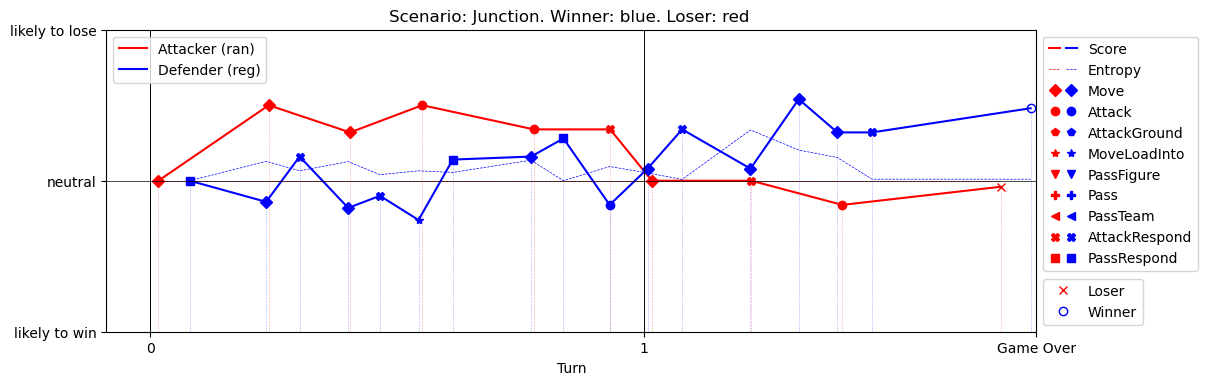

(                            time team      seed         action  meta_seed  \
 count                                                                       
 1.0   2021-03-11 21:52:28.612536  red  122340.0           Move          0   
 2.0   2021-03-11 21:52:28.891049  red  122340.0           Move          0   
 3.0   2021-03-11 21:52:29.096658  red  122340.0           Move          0   
 4.0   2021-03-11 21:52:29.278655  red  122340.0         Attack          0   
 5.0   2021-03-11 21:52:29.560483  red  122340.0         Attack          0   
 6.0   2021-03-11 21:52:29.752926  red  122340.0  AttackRespond          0   
 7.0   2021-03-11 21:52:29.858299  red  122340.0           Move          0   
 8.0   2021-03-11 21:52:30.109215  red  122340.0  AttackRespond          0   
 9.0   2021-03-11 21:52:30.338839  red  122340.0         Attack          0   
 
       meta_scenario  turn  red_figure_0_index  red_figure_0_kind  \
 count                                                              
 1

In [19]:
d_r,d_b=playAndAnalyzeTime(122340, red_models[1], blue_models[3],red_models[3])


In [ ]:
df_red,df_blue=playAndAnalyzeTime(1200, red_models[0], blue_models[1],red_models[5])


In [ ]:
plotEntropyTime(df_r,df_b,('reg', ''),('cls', ''),mm.winner,'Junction',('reg', '../models/Junction_RandomForestRegressor_20210301.joblib'))

## Tourney 

In [ ]:
dfs=[]
for i in range(3):
    s = random.randint(0, 1000000)
    r = random.randint(0, len(red_models)-1)
    b = random.randint(0, len(blue_models)-1)
    df_red,df_blue=playAndAnalyzeTime(s, red_models[r], blue_models[b])
    dfs.append(df_red)
    dfs.append(df_blue)
df=pd.concat(dfs).reset_index()

## Entropy regressor

In [ ]:
def plotgroupAgentePartita(df,value_y,kind):
    fig, axes = plt.subplots(len(df['team'].unique()),len(df['seed'].unique()), figsize=(15,10))
    for (joinGroup, group), ax in zip(df.groupby(['team','seed']), axes.flatten()):
        win=group['winner'].unique()
        title=f'{joinGroup}-> winner:{win}'
        group.plot(x='count', y=value_y, kind=kind,style='-o' ,ax=ax,title=title,ylim=[-1,1])

In [ ]:
plotgroupAgentePartita(df,'score','bar')

In [ ]:
plotgroupAgentePartita(df,'entropy','bar')

plotgroupAgentePartita(df,'Score','scatter')

plotgroupAgentePartita(df,'Entropia','scatter')

plotgroupAgentePartita(df,'Score','line')

plotgroupAgentePartita(df,'Entropia','line')

plotgroupAgentePartita(df,'Score','box')

plotgroupAgentePartita(df,'Entropia','box')

In [ ]:
def entropyAndScore(df,kind):
    fig, axes = plt.subplots(len(df['team'].unique()),len(df['seed'].unique()), figsize=(15,10))
    for (joinGroup, group), ax in zip(df.groupby(['team','seed']), axes.flatten()):
        win=group['winner'].unique()
        title=f'{joinGroup}-> winner:{win}'
        group.plot(x='count', y=['score'], kind=kind,style='-o', ax=ax,title=title,ylim=[-1,1],color='r')
        group.plot(x='count', y=['entropy'], kind=kind,style='-o', ax=ax,title=title,ylim=[-1,1],color='b')

In [ ]:
entropyAndScore(df,'scatter')

entropyAndScore(df,'line')

fig, axes = plt.subplots(1,len(df['seed'].unique()), figsize=(15,5))
for (joinGroup, group), ax in zip(df.groupby(['seed']), axes.flatten()):
    win=group['winner'].unique()
    title=f'{joinGroup}-> winner:{win}'
    group.plot(x=['count'], y=['score'], kind='scatter', ax=ax,title=title,ylim=[-1,1],c='team')


plot=df.groupby(['team','seed']).plot.bar(y='entropy')

boxplot=df.boxplot(column=['score', 'entropy'],by='team')


boxplot=df.boxplot(column=['score', 'entropy'],by='seed')

boxplot=df.boxplot(column=['score', 'entropy'],by=['seed','team'])

plot=df.groupby('team').plot.scatter(x='count',y='entropy',c='team')

plot=df.groupby('team').plot.scatter(x='count',y='score',c='team')